# Disaster Tweets: Simple Linear Model

Greetings! Thanks for checking out my code. 

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
stopwords = stopwords.words('english')
import re
import string
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

SEED = 42

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [68]:
def generate_submission(model, test_vectors, save=False):
    preds = model.predict(test_vectors)
    output = pd.DataFrame()
    output["id"] = test["id"]
    output["target"] = preds
    if save:
        output.to_csv(save+".csv", index=False)
    return output

In [2]:
train = pd.read_csv("assets/train.csv")
test = pd.read_csv("assets/test.csv")

**Data Cleaning Functions**

Many thanks to https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove#Data-Cleaning.

In [3]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html_tags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

# See https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    return text.translate(punc)

In [4]:
for dataset in [train, test]:
    dataset["text"] = dataset["text"].apply(remove_url).apply(remove_html_tags).apply(remove_emoji).apply(remove_punctuation).apply(str.lower)

In [5]:
train["text"].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

**Building the Vectors - CountVectorizer**

In [6]:
count_vectorizer = CountVectorizer()

ex_embeddings = count_vectorizer.fit_transform(train["text"][0:5])

In [7]:
print(ex_embeddings[0].todense().shape)
print(ex_embeddings[0].todense())

(1, 53)
[[0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0
  0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [8]:
train_vectors = count_vectorizer.fit_transform(train["text"])
test_vectors = count_vectorizer.transform(test["text"])

In [9]:
train_vectors.shape

(7613, 17798)

**Visualizing the Embeddings**

We use LDA to reduce dimensions by maximizing the separation of categories. LD1 (the first new axis that LDA creates) accounts for the most variation between categories.

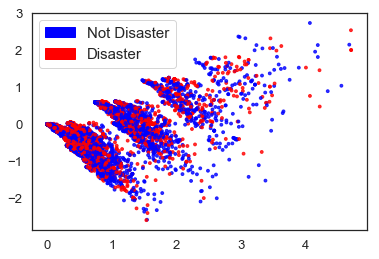

In [10]:
# Latent Semantical Analysis (LSA) - apply SVD to sparse input matrix, applied to text after it has been processed with TfidfVectorizer or CountVectorizer
def plot_LSA(X, y, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(X)
    lsa_scores = lsa.transform(X)
    color_mapper = {label:idx for idx,label in enumerate(set(y))}
    color_column = [color_mapper[label] for label in y]
    colors = ["blue", "red"]
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=0.8, c=y, cmap=matplotlib.colors.ListedColormap(colors))
        blue_patch = mpatches.Patch(color="blue", label="Not Disaster")
        red_patch = mpatches.Patch(color="red", label="Disaster")
        plt.legend(handles=[blue_patch, red_patch], prop={"size": 15})
        
plot_LSA(train_vectors, train["target"])
plt.show()

**Cross Val**

In [11]:
clf = linear_model.RidgeClassifier(random_state=SEED)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=3, scoring="f1")
scores

array([0.62001037, 0.55512195, 0.61985472])

**TfidfVectorizer**

In [12]:
tfidf_vectorizer = TfidfVectorizer()

train_vectors_tfidf = tfidf_vectorizer.fit_transform(train["text"])
test_vectors_tfidf = tfidf_vectorizer.transform(test["text"])

In [13]:
train_vectors_tfidf.shape

(7613, 17798)

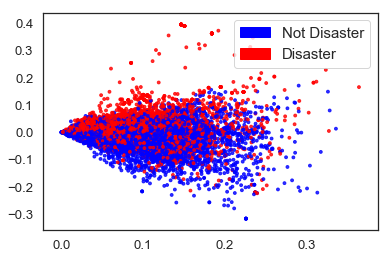

In [14]:
plot_LSA(train_vectors_tfidf, train["target"])

In [15]:
clf = linear_model.RidgeClassifier(random_state=SEED)
scores = model_selection.cross_val_score(clf, train_vectors_tfidf, train["target"], cv=3, scoring="f1")
scores

array([0.6376652 , 0.59652814, 0.66255144])

**Generate a Submission**

In [46]:
clf.fit(train_vectors_tfidf, train["target"])

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=42, solver='auto',
        tol=0.001)

In [49]:
output = generate_submission(clf, test_vectors_tfidf, True)
output.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


**GLoVe**

Incorporate context distance - higher values for words that often appear in the same context.

https://github.com/stanfordnlp/GloVe

In [44]:
df=pd.concat([train,test], sort=False)

In [45]:
def create_corpus(df):
    corpus = []
    for tweet in tqdm(df["text"]):
        words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
        corpus.append(words)
    return corpus

In [46]:
corpus = create_corpus(df)

100%|██████████| 10876/10876 [00:00<00:00, 11361.27it/s]


In [56]:
embedding_dict={}
with open('assets/glove.6B.100d.txt','r', encoding="utf-8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [57]:
MAX_LEN = 50
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)
tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating="post", padding="post")

In [58]:
word_index = tokenizer.word_index
len(word_index)

20357

In [59]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    vector = embedding_dict.get(word)
    if vector is not None:
        embedding_matrix[i] = vector

100%|██████████| 20357/20357 [00:00<00:00, 647393.60it/s]


**Keras Model**

In [60]:
model = Sequential()

embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

optimizer = Adam(lr=1e-5)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [61]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           2035800   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 2,078,105
Trainable params: 42,305
Non-trainable params: 2,035,800
_________________________________________________________________


In [62]:
train_keras = tweet_pad[:train.shape[0]]
test_keras = tweet_pad[train.shape[0]:]

In [63]:
len(test), len(test_keras)

(3263, 3263)

In [66]:
X_train, X_valid, y_train, y_valid = train_test_split(train_keras, train["target"], test_size=0.15)
X_train.shape, X_valid.shape

((6471, 50), (1142, 50))

In [67]:
model.fit(X_train, y_train, batch_size=4, epochs=15, validation_data=(X_valid, y_valid), verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 27s - loss: 0.6918 - acc: 0.5699 - val_loss: 0.6902 - val_acc: 0.5727
Epoch 2/15
 - 25s - loss: 0.6875 - acc: 0.5699 - val_loss: 0.6826 - val_acc: 0.5727
Epoch 3/15
 - 24s - loss: 0.6747 - acc: 0.5699 - val_loss: 0.6624 - val_acc: 0.5727
Epoch 4/15
 - 25s - loss: 0.6472 - acc: 0.5823 - val_loss: 0.6193 - val_acc: 0.6357
Epoch 5/15
 - 25s - loss: 0.6148 - acc: 0.6949 - val_loss: 0.5890 - val_acc: 0.7522
Epoch 6/15
 - 26s - loss: 0.5888 - acc: 0.7285 - val_loss: 0.5726 - val_acc: 0.7364
Epoch 7/15
 - 26s - loss: 0.5693 - acc: 0.7371 - val_loss: 0.5651 - val_acc: 0.7364
Epoch 8/15
 - 26s - loss: 0.5572 - acc: 0.7481 - val_loss: 0.5562 - val_acc: 0.7478
Epoch 9/15
 - 26s - loss: 0.5496 - acc: 0.7535 - val_loss: 0.5484 - val_acc: 0.7391
Epoch 10/15
 - 26s - loss: 0.5501 - acc: 0.7500 - val_loss: 0.5427 - val_acc: 0.7548
Epoch 11/15
 - 28s - loss: 0.5485 - acc: 0.7510 - val_loss: 0.5

In [81]:
yhat = model.predict(test_keras)
preds = np.round(yhat).astype(int).reshape(len(test_keras))
output = pd.DataFrame()
output["id"] = test["id"]
output["target"] = preds
output.to_csv("submissions/keras-glove-1.csv", index=False)

In [86]:
model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_valid, y_valid), verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 2s - loss: 0.5198 - acc: 0.7725 - val_loss: 0.5097 - val_acc: 0.7758
Epoch 2/15
 - 2s - loss: 0.5240 - acc: 0.7694 - val_loss: 0.5093 - val_acc: 0.7776
Epoch 3/15
 - 2s - loss: 0.5228 - acc: 0.7707 - val_loss: 0.5100 - val_acc: 0.7767
Epoch 4/15
 - 2s - loss: 0.5159 - acc: 0.7724 - val_loss: 0.5097 - val_acc: 0.7767
Epoch 5/15
 - 2s - loss: 0.5240 - acc: 0.7687 - val_loss: 0.5091 - val_acc: 0.7767
Epoch 6/15
 - 2s - loss: 0.5213 - acc: 0.7747 - val_loss: 0.5096 - val_acc: 0.7767
Epoch 7/15
 - 2s - loss: 0.5203 - acc: 0.7693 - val_loss: 0.5096 - val_acc: 0.7767
Epoch 8/15
 - 2s - loss: 0.5203 - acc: 0.7701 - val_loss: 0.5097 - val_acc: 0.7758
Epoch 9/15
 - 2s - loss: 0.5188 - acc: 0.7716 - val_loss: 0.5094 - val_acc: 0.7767
Epoch 10/15
 - 2s - loss: 0.5224 - acc: 0.7714 - val_loss: 0.5093 - val_acc: 0.7750
Epoch 11/15
 - 2s - loss: 0.5214 - acc: 0.7714 - val_loss: 0.5085 - val_acc: 0.7767
Epoch 12/15
 - 2s - loss: 0.5229 - ac

In [84]:
yhat = model.predict(test_keras)
preds = np.round(yhat).astype(int).reshape(len(test_keras))
output = pd.DataFrame()
output["id"] = test["id"]
output["target"] = preds
output.to_csv("submissions/keras-glove-3.csv", index=False)

### Conclusion

Thanks very much for reading; I hope you enjoyed learning how to build a linear model using vectorized NLP data. If you did, be sure to upvote so you can find this notebook again easily in your Favorites tab.

Until next time, happy coding :)